## TODO
satohara_resultsと統合

### このnotebookを作成した際の反省
satohara_resultsと何が違う？ -> 自分の手元の結果を確認しているという点で違う。  
だが、自分の手元の結果はどこから読み込んでいるのか 一眼で全くわから内容になっている。  
だからゴミ  
このnotebookで何がしたいのかをまず考えて、それが1番最初に見てわかるようにする。  
notebookを最後まで見ないとわからない構成だと何が何だかわからなくなる。

In [1]:
import sys
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, Agent, agent_metrics, show_reward, settings
### path load

import japanize_matplotlib
import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from blur_funcs import kernel1,kernel2,FUNCS_GR, ACTIONS_GR, ACTIONS_GR2, FUNCS_RN, ACTIONS_RN, ACTIONS_WO_RN_BLUR

SEED = 0
device = 'cuda:0'

In [3]:
np.load('channel02_weight005_seed00/gauss/c3_metrics.npy')[:, -1].mean()

0.01408958409766201

100%|██████████| 10000/10000 [00:03<00:00, 3117.48it/s]


mse = 0.046+-0.0106


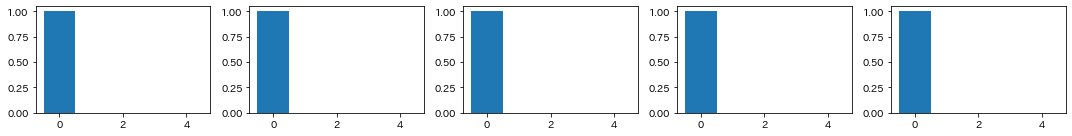

100%|██████████| 10000/10000 [00:04<00:00, 2122.75it/s]


mse = 0.046+-0.0110


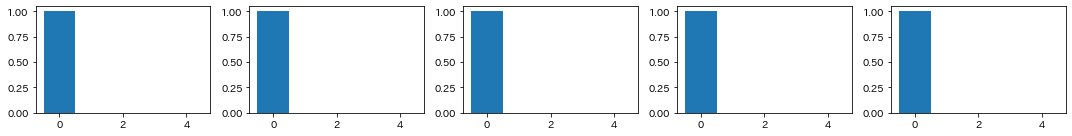

100%|██████████| 10000/10000 [00:02<00:00, 3463.33it/s]


mse = 0.047+-0.0111


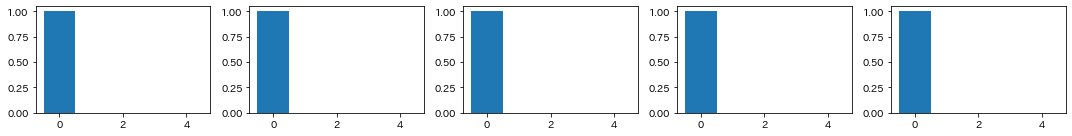

In [3]:
def DummyNet(s):
    return torch.tensor([1, 0, 0, 0, 0])[None, ...], torch.tensor([1, 0, 0, 0, 0])[None, ...], 
     
# Qnetでの性能を測定
labels = ['gauss', 'random', 'smooth']
actions = [lambda x: x] + ACTIONS_GR
# setting3, setting4
seed = 0
# for setting_num in [3, 4]:
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    channel = setting.CHANNEL
    weight = setting.WEIGHT
    RESULT_PATH = os.path.join(
        'channel%02d_weight%03d_seed%02d' % (channel, int(100*weight), seed)
    )
    # 3種類のフィルタ
    for l in range(3):
        # 回数を1~5
#         for c in range(1, 6):
        c = 3
        # データの読み込み
        context = np.load(
            os.path.join('data/GR/test', labels[l], f'c{c}_dataset.npz')
        )
        Dy = torch.from_numpy(context['test_dataset'])
        Dx = torch.from_numpy(context['original_dataset'])
        # MSEの算出
        result = agent_metrics(Dy, Dx, DummyNet, actions, channel=channel)
        print(f'mse = {result[:, -1].mean():.3f}+-{result[:, -1].std():.4f}')

        fig, axes = plt.subplots(1, 5, figsize=(15, 2))
        for j in range(5):
            axes[j].hist(result[:, j], bins=np.arange(6) - 0.5, density=True)
        plt.tight_layout()
        plt.show()

2 channel weight: =  0.0
RESULT_PATH channel02_weight000_seed00


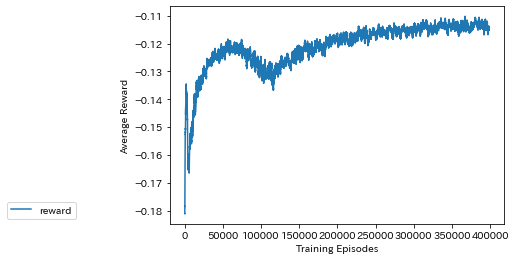

MODEL_PATH channel02_weight000_seed00/Qnet020000.pth
2 channel weight: =  0.05
RESULT_PATH channel02_weight005_seed00


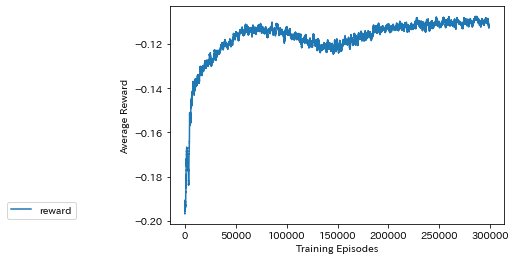

MODEL_PATH channel02_weight005_seed00/Qnet020000.pth


FileNotFoundError: [Errno 2] No such file or directory: 'channel02_weight005_seed00/Qnet020000.pth'

In [4]:
# 実験条件を指定
ACTIONS = ACTIONS_GR
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [3, 4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()
    
    actions = [lambda x: x] + ACTIONS
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    print('MODEL_PATH', MODEL_PATH)
    Qnet.load_state_dict(
        torch.load(MODEL_PATH)
    )

`data/GR3.0/test`からデータを読み込む。  
ランダムにフィルタを選択した場合の復元結果のMSEを測定する。  
`results/GR3.0/init_random`に結果を保存する。

In [5]:
labels = ['gauss', 'random', 'smooth']
actions = [lambda x: x] + ACTIONS_GR
# 結果の対象パスどこ
# setting3, setting4
seed = 0
RESULT_PATH = 'results/GR3.0/'
# 3種類のフィルタ
for l in range(3):
    # 回数を1~5
    for c in range(1, 6):
        # データの読み込み
        context = np.load(
            os.path.join('data/GR3.0/test', labels[l], f'c{c}_dataset.npz')
        )
        Dy = context['test_dataset']
        Dx = context['original_dataset']
        print(Dy.shape[0])
        # 入力画像のMSE
        init_mse = np.mean((Dy - Dx)**2, axis=(1, 2))
        # ランダムに行動を選択した場合のMSE
        random_mse = []
        # random actions
        np.random.seed(seed + 100)
        aN = np.random.choice(len(actions), (Dy.shape[0], 5))
        for n in range(Dy.shape[0]):
            xn = Dx[n]
            yn = Dy[n].copy()
            an = aN[n]
            # ステップ数
            for a in an:
                yn = actions[a](yn)
            random_mse.append(
                np.mean((yn - xn)**2)
            )
        random_mse = np.array(random_mse)
        # 結果の保存
        os.makedirs(os.path.join(RESULT_PATH, 'init_random'), exist_ok=True)
        result = np.c_[init_mse, random_mse]
        print()
        print('init', init_mse.mean(), init_mse.std())
#         print('init', result[:, 0].mean(), result[:, 0].std())
#         print('random', result[:, 1].mean(), result[:, 1].std())
        print('random', random_mse.mean(), random_mse.std())
        np.save(os.path.join(RESULT_PATH, 'init_random', f'{labels[l]}_c{c}_metric.npy'), result)

10000

init 0.02281997649605797 0.005335388064689591
random 0.04896504902976626 0.046853441339708
10000

init 0.03407595348683115 0.0077289300149506815
random 0.04251593011708336 0.029755091953884313
10000

init 0.041754009905595794 0.009587872085103213
random 0.042624544717492927 0.019091624359795296
10000

init 0.04716768946965732 0.011038493897916595
random 0.04681365377424891 0.01687281191113485
10000

init 0.05123841222416039 0.012202082100247692
random 0.053034825425595865 0.020139167454434507
10000

init 0.028740643939728926 0.007090986113147228
random 0.04527218947750929 0.039846501971139876
10000

init 0.03848262540650478 0.009021567951811384
random 0.041334952711716125 0.021526643050339328
10000

init 0.04602599343577285 0.01097100514796247
random 0.045802802768378816 0.01688513786312203
10000

init 0.05111559965701586 0.012379509899865332
random 0.05335890269187994 0.020946199298700757
10000

init 0.054948094564742096 0.013501489993416563
random 0.0592228195070786 0.02572397

データを`data/GR??`から読み込む。  
$\lambda = 0, \lambda = 0.05$の2つの学習済みモデルの復元結果のMSEを測定した。  
結果を`results/[gauss|random|smooth]/`に保存  

In [12]:
# Qnetでの性能を測定
labels = ['gauss', 'random', 'smooth']
actions = [lambda x: x] + ACTIONS_GR
# setting3, setting4
seed = 0
# for setting_num in [3, 4]:
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    channel = setting.CHANNEL
    weight = setting.WEIGHT
    RESULT_PATH = os.path.join(
        'channel%02d_weight%03d_seed%02d' % (channel, int(100*weight), seed)
    )
    Qnet = QNet(c=channel, m=[20, 20, len(actions)])
#     MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    print('MODEL_PATH', MODEL_PATH)
    Qnet.load_state_dict(
        torch.load(MODEL_PATH)
    )
    # 3種類のフィルタ
    for l in range(3):
        # 回数を1~5
        for c in range(1, 6):
            # データの読み込み
            context = np.load(
                os.path.join('data/GR/test', labels[l], f'c{c}_dataset.npz')
            )
            Dy = torch.from_numpy(context['test_dataset'])
            Dx = torch.from_numpy(context['original_dataset'])
            # MSEの算出
            result = agent_metrics(Dy, Dx, Qnet, actions, channel=channel)
            print(f'mse = {result[:, -1].mean():.3f}+-{result[:, -1].std():.4f}')
            # 結果の保存
            os.makedirs(os.path.join(RESULT_PATH, labels[l]), exist_ok=True)
            np.save(os.path.join(RESULT_PATH, labels[l], f'c{c}_metric.npy'), result)

  0%|          | 0/10000 [00:00<?, ?it/s]

MODEL_PATH channel02_weight005_seed00/Qnet020000.pth


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014+-0.0064


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015+-0.0053


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.019+-0.0067


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.043+-0.0207


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.064+-0.0268


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.014+-0.0067


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.016+-0.0059


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.021+-0.0091


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.048+-0.0240


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.066+-0.0288


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.015+-0.0062


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.017+-0.0053


100%|██████████| 10000/10000 [01:11<00:00, 139.70it/s]


mse = 0.025+-0.0102


  0%|          | 0/10000 [00:00<?, ?it/s]

mse = 0.054+-0.0241


100%|██████████| 10000/10000 [01:25<00:00, 116.89it/s]

mse = 0.069+-0.0278


保存したMSEの測定結果を`results/GR3.0/init_random, channel02_weight00{w}_seed0/[gauss|random|smooth]/`から読み込む。  
表形式のデータに加工する。  
グラフ化する。  

In [1]:
np

NameError: name 'np' is not defined

gauss
0.023(0.0053)	0.034(0.0077)	0.042(0.0096)	0.047(0.0110)	0.051(0.0122)	
0.049(0.0469)	0.043(0.0298)	0.043(0.0191)	0.047(0.0169)	0.053(0.0201)	
0.019(0.0113)	0.017(0.0075)	0.020(0.0081)	0.042(0.0197)	0.056(0.0235)	
0.014(0.0064)	0.015(0.0053)	0.019(0.0067)	0.043(0.0207)	0.064(0.0268)	

random
0.029(0.0071)	0.038(0.0090)	0.046(0.0110)	0.051(0.0124)	0.055(0.0135)	
0.045(0.0398)	0.041(0.0215)	0.046(0.0169)	0.053(0.0209)	0.059(0.0257)	
0.019(0.0117)	0.017(0.0079)	0.023(0.0113)	0.045(0.0218)	0.058(0.0253)	
0.014(0.0067)	0.016(0.0059)	0.021(0.0091)	0.048(0.0240)	0.066(0.0288)	

smooth
0.030(0.0070)	0.040(0.0091)	0.047(0.0111)	0.052(0.0125)	0.056(0.0136)	
0.044(0.0364)	0.041(0.0190)	0.047(0.0167)	0.055(0.0218)	0.061(0.0266)	
0.019(0.0108)	0.017(0.0073)	0.026(0.0114)	0.050(0.0224)	0.060(0.0238)	
0.015(0.0062)	0.017(0.0053)	0.025(0.0102)	0.054(0.0241)	0.069(0.0278)	




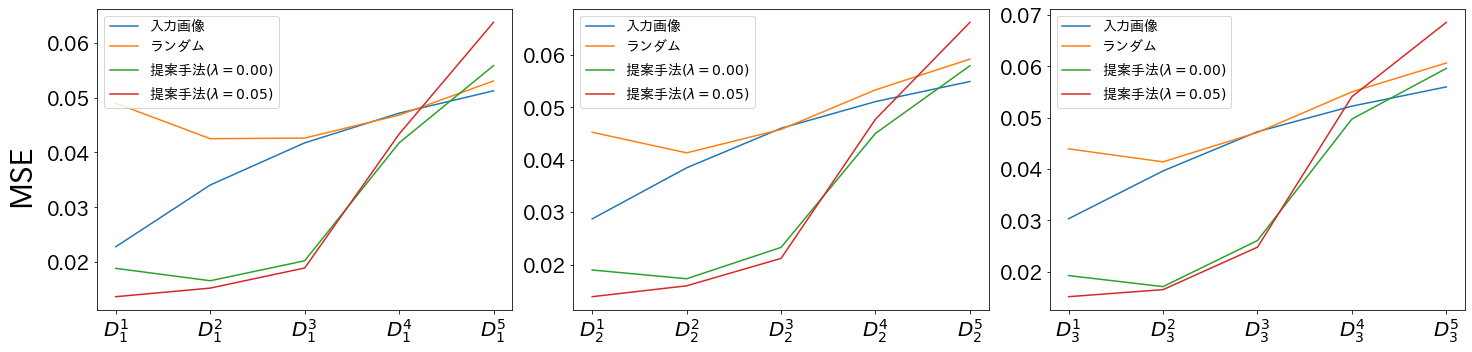

In [4]:
# 測定したMSEの可視化
base = ''
template_init_random = 'results/GR3.0/init_random/{label}_c{c}_metric.npy'
template_model = 'channel{channel:02d}_weight{weight:03d}_seed00/{label}/c{c}_metric.npy'
labels = ['gauss', 'random', 'smooth']
t = 0
# 結果を表で保存
# 1次元目は、どのフィルタを用いてテストデータを作成したか
# [入力画像, ランダム, 提案手法(lambda = 0.00), 提案手法(lambda = 0.05)]で
# データセット
table = np.zeros((3, 4, 10))
for l in range(len(labels)):
    label = labels[l]
    for c in range(1, 6):
        mse_index = 2*(c-1)
        std_index = 2*(c-1) + 1
        init_random = np.load(os.path.join(base, template_init_random.format(label=label, c=c)))
        init_mse = init_random[:, 0]
        table[l, 0, mse_index] = init_mse.mean()
        table[l, 0, std_index] = init_mse.std()
        random_mse = init_random[:, 1]
        table[l, 1, mse_index] = random_mse.mean()
        table[l, 1, std_index] = random_mse.std()
        model1_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=0, label=label, c=c))
        )[:, -1]
        table[l, 2, mse_index] = model1_mse.mean()
        table[l, 2, std_index] = model1_mse.std()
        model2_mse = np.load(
            os.path.join(base, template_model.format(channel=2, weight=5, label=label, c=c))
        )[:, -1]
        table[l, 3, mse_index] = model2_mse.mean()
        table[l, 3, std_index] = model2_mse.std()
np.save(os.path.join(base, 'metrics_table.npy'), table)

for l in range(3):
    print(labels[l])
    for m in range(4):
        for c in range(5):
            print(f'{table[l, m, 2*c]:.3f}({table[l, m, 2*c+1]:.4f})', end='\t')
        print()
    print()

tick_labels = [
    ['$D_1^1$', '$D_1^2$', '$D_1^3$', '$D_1^4$', '$D_1^5$'],
    ['$D_2^1$', '$D_2^2$', '$D_2^3$', '$D_2^4$', '$D_2^5$'],
    ['$D_3^1$', '$D_3^2$', '$D_3^3$', '$D_3^4$', '$D_3^5$'],
]

labels = ['入力画像', 'ランダム', '提案手法$(\lambda = 0.00)$', '提案手法$(\lambda = 0.05)$']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
print()
for l in range(3):
    axes[l].set_xticks(range(5))
    axes[l].set_xticklabels(tick_labels[l])
    axes[l].tick_params(labelsize=20)
    for m in range(4):
        d = table[l, m, np.arange(0, 10, 2)]  #FIXME
        axes[l].plot(d, label=labels[m])
    axes[l].legend(loc='upper left', fontsize=14)
fig.text(-0.02, 0.5, 'MSE', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

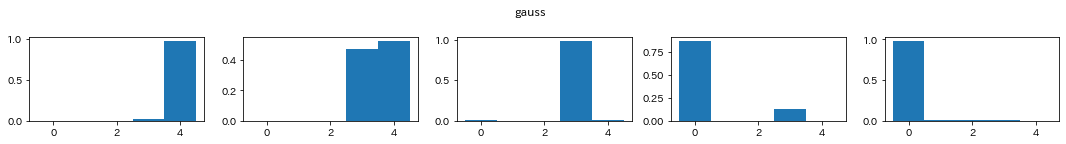

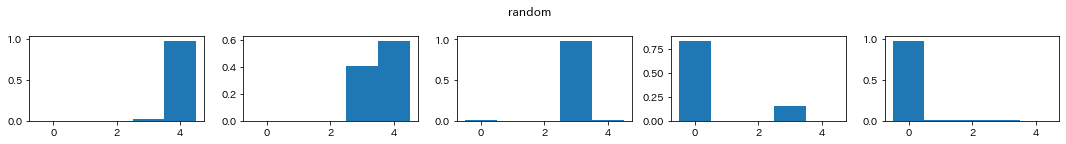

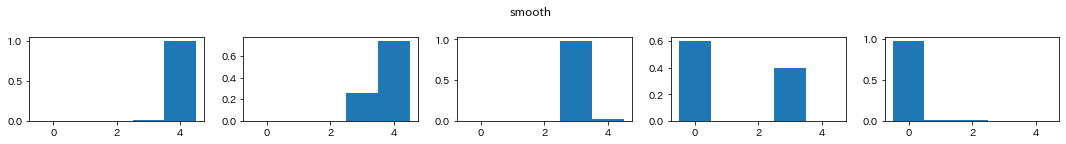

In [5]:
for label in ['gauss', 'random', 'smooth']:
    result_gauss = np.load(f'channel02_weight005_seed00/{label}/c3_metric.npy')
    fig, axes = plt.subplots(1, 5, figsize=(15, 2))
    fig.suptitle(label)
    for j in range(5):
        axes[j].hist(result_gauss[:, j], bins=np.arange(6) - 0.5, density=True)
    plt.tight_layout()
    plt.show()